# Imports


In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import pymer4 as pymer4
from pymer4.models import Lmer

In [2]:
# set path to data if not opened in folder
p = './data/'

# Temporal Binding

## Data Processing

In [3]:
# load data
behavior_raw= pd.read_csv( p + 'PI_results_design.csv')

# set data types
behavior_raw[['ed','rt']] = behavior_raw[['ed','rt']].apply(pd.to_numeric, axis=1)
behavior_raw['rd'] = behavior_raw['rd'].astype("string")  # needs to be string before category for R conversion
behavior_raw[['rd','condition']] = behavior_raw[['rd','condition']].astype("category")

# delete VP 18 (did not follow instructions in block 3)
behavior_raw =  behavior_raw.loc[behavior_raw["id"] !=18]

(0.0, 5.0)

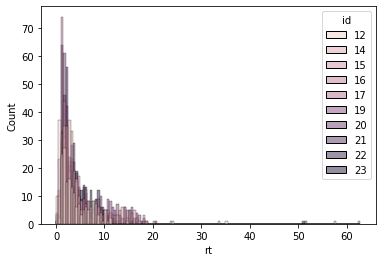

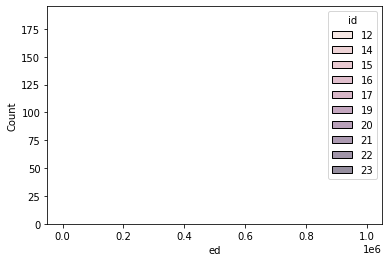

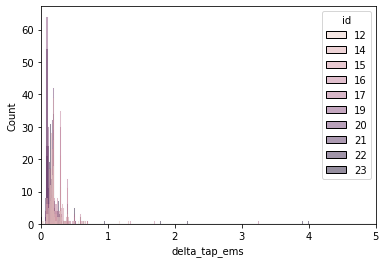

In [4]:
# check raw data (reaction times and estimated times) -> warning, slow

fig, ax = plt.subplots()
hist = sns.histplot(behavior_raw, x = 'rt',ax =ax, hue = 'id')
#ax.set_xlim(0,5) # remove outliers for visualization

fig, ax = plt.subplots()
hist = sns.histplot(behavior_raw, x = 'ed',ax =ax, hue = 'id')

fig, ax = plt.subplots()
hist = sns.histplot(behavior_raw, x = 'delta_tap_ems',ax =ax, hue = 'id')
ax.set_xlim(0,5) # remove outliers for visualization

In [5]:
# clean data: removes outliers trials that have outliers either in rt or ed
cols = ['rt', 'ed','delta_tap_ems'] # relevant cols

# calculate quantiles and IQR
Q1 = behavior_raw[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = behavior_raw[cols].quantile(0.75)
IQR = Q3 - Q1

# return a boolean array of the rows with (any) non-outlier column values
condition = ~((behavior_raw[cols] < (Q1 - 3 * IQR)) | (behavior_raw[cols] > (Q3 + 3 * IQR))).any(axis=1)

# filter our dataframe based on condition
behavior = behavior_raw[condition]
behavior_del = behavior_raw[-condition]

In [6]:
#count deleted trials
print('Deleted trials:',len(behavior_del))

#per pID
print('Deleted trials per pID')
print(behavior_del['id'].value_counts())

print('mean')
print(behavior_del['id'].value_counts().mean())
print('sd')
print(behavior_del['id'].value_counts().std())

#per condition
print('Deleted trials per condition')
print(behavior_del['condition'].value_counts())
print('mean')
print(behavior_del['condition'].value_counts().mean())
print('sd')
print(behavior_del['condition'].value_counts().std())

print(len(behavior))

Deleted trials: 110
Deleted trials per pID
id
15    28
19    25
23    16
16    12
17     9
12     8
14     6
20     3
22     3
Name: count, dtype: int64
mean
12.222222222222221
sd
9.107384061542835
Deleted trials per condition
condition
ems_random    57
ems_bci       30
baseline      23
Name: count, dtype: int64
mean
36.666666666666664
sd
17.95364401266031
2140


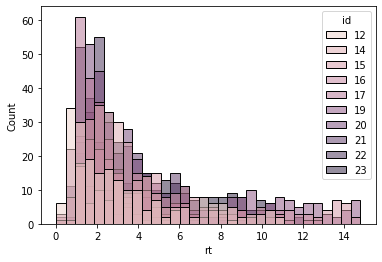

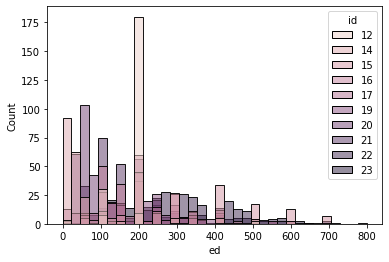

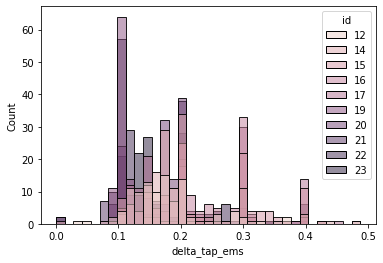

In [7]:
#check cleaned data
fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'rt',ax =ax, hue = 'id')
#ax.set_xlim(0,5) # remove outliers for visualization

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'ed',ax =ax, hue = 'id')

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'delta_tap_ems',ax =ax, hue = 'id')


In [8]:
# with stimulation condition + time condition+ rd as y
behavior[['rd']] = behavior[['rd']].apply(pd.to_numeric, axis=1)
behavior[['ed']] = behavior[['ed']].apply(pd.to_numeric, axis=1)
# diff = ed - 350 because 350 is the mean of the different time intervals; maybe add *-1  to adapt direction of the plot
behavior["diff"]= behavior['ed']
behavior[['rd']] = behavior[['rd']].astype("category")

behavior_means = behavior.groupby(['id','condition'],as_index=False)['diff'].mean()

/var/folders/04/2q4w_vgn0_7dtkxyll6j2gx40000gn/T/ipykernel_41645/851411184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior[['rd']] = behavior[['rd']].apply(pd.to_numeric, axis=1)
/var/folders/04/2q4w_vgn0_7dtkxyll6j2gx40000gn/T/ipykernel_41645/851411184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior[['ed']] = behavior[['ed']].apply(pd.to_numeric, axis=1)
/var/folders/04/2q4w_vgn0_7dtkxyll6j2gx40000gn/T/ipykernel_41645/851411184.py:5: SettingWithCopyWarning: 
A value is trying to b

## Plot

/var/folders/04/2q4w_vgn0_7dtkxyll6j2gx40000gn/T/ipykernel_41645/2867965326.py:38: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(data = data_means, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)


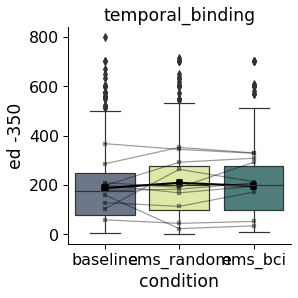

In [10]:
palette = ['#576683', '#E4f392', '#337775']
cats= ['baseline','ems_random','ems_bci'] 
ylabel = 'ed -350'
xlabel = 'condition'
title = 'temporal_binding'
data = behavior
data_means = behavior_means
y = 'diff'
x = "condition"
hue = "id"
hue2 = 'rd'

# runs plot but needs post processing in affinty desiger
cats_0 = data[data[x]==cats[0]]
cats_1 = data[data[x]==cats[1]]
cats_2 = data[data[x]==cats[2]]

pairs = [(cats[0], cats[1],cats[2])]

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    # show boxplots
    ax = sns.boxplot(data = data,x = x, y = y,  order= ['baseline','ems_random','ems_bci'] ,  palette= palette )
    for patch in ax.patches: # adapt alpha
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .9))

    # show line connecting means
    ax =  sns.pointplot(data = data,x = x, y = y, markers="s" ,color = 'black', order = cats)
    
     #  show lines connecting pid means observations    
    ax = sns.lineplot(data = data_means, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)
    
    ax = sns.scatterplot(data=data_means, x=x, y=y,s=10, legend= True, marker="s",color = 'black',edgecolor = 'black',alpha=0.4)
        
    # ax.invert_yaxis()
    # add_stat_annotation(ax, data=data_means, x=x, y=y, box_pairs=[("baseline", "ems_random"), ("baseline", "ems_bci"), ('ems_random', 'ems_bci')], test='t-test_paired', text_format='star', loc='outside', verbose=2)

    handles, labels = ax.get_legend_handles_labels()  
    
    #plt.legend(handles[3:6],labels[3:6],frameon=True,loc = 'upper left',labelspacing =0.3)
    
    # label_plot_for_subcats(ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    plt.show()

# fig.savefig('results/'+title + '_'+'.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig('results/'+title + '_' +'.png', format='png', transparent=True, bbox_inches='tight', dpi=300)

## Analysis

In [11]:
print(behavior.groupby('condition')['ed'].agg(['mean','std']))

                  mean         std
condition                         
baseline    187.554333  138.929693
ems_bci     195.979138  138.208467
ems_random  208.592486  140.084898


### Modeling

- switched from rpy2 to pymer4, because it is less annoying with importing / exporting from python to R
- not sure if of this is still necessary, but since pymer4 is based on rpy2, this might be the case

In [12]:
# packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
# from rpy2.robjects.packages import importr
# from rpy2.robjects.vectors import StrVector
# utils = importr("utils")
# utils.chooseCRANmirror(ind=1)

In [13]:
# packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot', 'Matrix')
# from rpy2.robjects.vectors import StrVector
# utils.install_packages(StrVector(packnames))

In [14]:
# full model
full_model = Lmer("diff ~ condition + (1|id)", data = behavior)
display(full_model.fit(REML = False, factors={"condition": ["baseline", "ems_random", "ems_bci"]}))
#full_model.plot_summary()

/opt/homebrew/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: diff~condition+(1|id)

Family: gaussian	 Inference: parametric

Number of observations: 2140	 Groups: {'id': 10.0}

Log-likelihood: -13000.591 	 AIC: 26011.181

Random effects:

                 Name        Var      Std
id        (Intercept)   8297.069   91.088
Residual               10935.247  104.572

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),189.413,132.447,246.379,29.065,10.240,6.517,0.000,***
condition1,7.285,-3.499,18.068,5.502,2128.019,1.324,0.186,
condition2,22.630,11.741,33.519,5.556,2128.019,4.073,0.000,***


### Likelihood Ratio Test

In [15]:
# null model without stimulation condition 
null_model = Lmer("diff ~ (1|id)", data = behavior)
null_model.fit(REML = False, summarize=False)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.



/opt/homebrew/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


In [16]:
pymer4.stats.lrt([null_model,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,diff~(1|id),3,26024.313834,26041.316713,-13009.156917,26018.313834,,,,
1,diff~condition+(1|id),5,26011.181089,26039.519219,-13000.590544,26001.181089,17.132745,2.0,0.00019,***


#### Post-hoc Test

In [17]:
# post hoc test condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="condition", p_adjust = "bonf")
print(comparisons)

P-values adjusted by bonf method for 3 comparisons
                Contrast  Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
1     baseline - ems_bci    -7.285 -20.466    5.897  5.502  2128.019  -1.324   
2  baseline - ems_random   -22.630 -35.941   -9.320  5.556  2128.019  -4.073   
3   ems_bci - ems_random   -15.346 -28.699   -1.992  5.573  2128.048  -2.753   

   P-val  Sig  
1  0.557       
2  0.000  ***  
3  0.018    *  


# Agency Question

## Data Processing

In [18]:
questionaire= pd.read_excel(p + 'questionaire.xlsx') 

good_pid = ['12', '14', '15', '16', '17', '19', '20', '21', '22', '23']
questionaire['pID'] = questionaire['pID'].astype(str)
questionaire = questionaire.loc[questionaire['pID'].isin(good_pid)]
questionaire_long = questionaire.melt(id_vars= ['pID'],value_vars=['baseline','passive','agency'])

## Plot

/var/folders/04/2q4w_vgn0_7dtkxyll6j2gx40000gn/T/ipykernel_41645/3557096530.py:31: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(data = data, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)


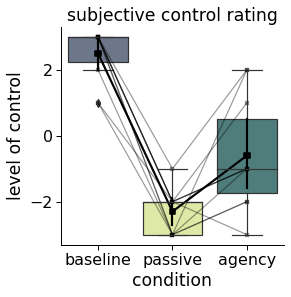

In [19]:
palette = ['#576683', '#E4f392', '#337775']
cats= ['item_baseline', 'item_passive', 'item_agency']
ylabel = 'level of control'
xlabel = 'condition'
title = 'subjective control rating'
data = questionaire_long
y = 'value'
x = 'variable'
hue = 'pID'

with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(4,4))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True
         # show boxplots
        ax = sns.boxplot(data = data, x = x, y = y,  palette= palette)
        for patch in ax.patches: # adapt alpha
             r, g, b, a = patch.get_facecolor()
             patch.set_facecolor((r, g, b, .9))

                   
        # show line connecting means
        sns.pointplot(
            data = data,x = x, y = y, markers="s", color = 'black')
        
        # pId means
        
        ax = sns.lineplot(data = data, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)
    
        ax = sns.scatterplot(data=data, x=x, y=y,s=10, legend= True, marker="s",color = 'black',edgecolor = 'black',alpha=0.4)

        #sns.scatterplot(data = data,x = x, y = y, markers="^",color = 'black')
        # add_stat_annotation(ax, data=data, x=x, y=y, box_pairs=[("baseline", "passive"), ("baseline", "agency"), ('passive', 'agency')], test='t-test_ind', text_format='star', loc='outside', verbose=2)
        
        # Label and show
        # label_plot_for_subcats(ax)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

        plt.show()
        # fig.savefig('results/'+title + '_' +'.png', format='png', transparent=True, bbox_inches='tight', dpi=300)
        # fig.savefig('results/'+title + '_'+'.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

## Modeling


In [20]:
#full model
full_model = Lmer('value ~ variable + (1|pID)', data = questionaire_long)
display(full_model.fit(REML = False,factors={"variable": ["baseline", "passive", "agency"]}))

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: value~variable+(1|pID)

Family: gaussian	 Inference: parametric

Number of observations: 30	 Groups: {'pID': 10.0}

Log-likelihood: -45.384 	 AIC: 100.768

Random effects:

                 Name    Var    Std
pID       (Intercept)  0.190  0.436
Residual               1.043  1.021

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),2.5,1.812,3.188,0.351,28.641,7.119,0.0,***
variable1,-4.8,-5.695,-3.905,0.457,20.000,-10.508,0.0,***
variable2,-3.1,-3.995,-2.205,0.457,20.000,-6.786,0.0,***


In [21]:
#null model
null_model = Lmer('value ~ (1|pID)', data = questionaire_long)
null_model.fit(REML = False, summarize=False)

boundary (singular) fit: see help('isSingular') 



In [22]:
# likelihood ratio test
pymer4.stats.lrt([null_model,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,value~(1|pID),3,140.493331,144.696923,-67.246665,134.493331,,,,
1,value~variable+(1|pID),5,100.767751,107.773738,-45.383875,90.767751,43.72558,2.0,0.0,***


In [23]:
# post hoc test condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="variable",p_adjust = "bonf")

print(comparisons)

P-values adjusted by bonf method for 3 comparisons
             Contrast  Estimate  2.5_ci  97.5_ci     SE    DF  T-stat  P-val  \
1  baseline - passive       4.8   3.607    5.993  0.457  20.0  10.508  0.000   
2   baseline - agency       3.1   1.907    4.293  0.457  20.0   6.786  0.000   
3    passive - agency      -1.7  -2.893   -0.507  0.457  20.0  -3.722  0.004   

   Sig  
1  ***  
2  ***  
3   **  


In [24]:
# participants
print(questionaire.age.mean())
print(questionaire.age.std())

29.6
4.141926551202418


# EEG: Slope

In [25]:
slope = pd.read_csv( p + 'PI_results_design_slope_processed.csv')
#data cleaning happend somewhere else

## Plot

/var/folders/04/2q4w_vgn0_7dtkxyll6j2gx40000gn/T/ipykernel_41645/2126173901.py:33: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(data = data, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)


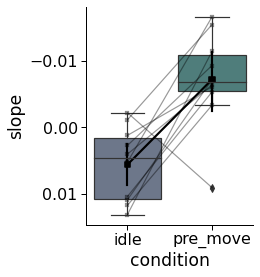

In [26]:
# plot a box plot of the slope values by condition
#slope.boxplot(column=['slopes'], by=['condition'], figsize=(12,8))

palette = ['#576683', '#337775']
cats= ['idle', 'pre_move']
ylabel = 'slope'
xlabel = 'condition'
title = 'slope'
data = slope
y = 'slopes'
x = 'condition'
hue = 'id'

with sns.plotting_context('paper', font_scale = 1.8):

      ### Create new plot
      fig, ax = plt.subplots(1, 1, figsize=(3,4))
      fig.patch.set_alpha(1)

      sns.despine() #bottom=True, left=True
      # show boxplots
      ax = sns.boxplot(data = data, x = x, y = y,  palette= palette)
      for patch in ax.patches: # adapt alpha
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .9))

                  
      # show line connecting means
      sns.pointplot(data = data,x = x, y = y, markers="s" ,color = 'black')
      
      # pId means
      
      ax = sns.lineplot(data = data, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)
   
      ax = sns.scatterplot(data=data, x=x, y=y,s=10, legend= True, marker="s",color = 'black',edgecolor = 'black',alpha=0.4)

      #sns.scatterplot(data = data,x = x, y = y, markers="^",color = 'black')

      plt.gca().invert_yaxis()

      # add statannotation for the pair 'idle' and 'pre_move'
   #    add_stat_annotation(ax, data=data, x=x, y=y, box_pairs=[("idle", "pre_move")], test='t-test_ind', text_format='star', loc='outside', verbose=2)
      

      # Label and show
      # label_plot_for_subcats(ax)
      # ax.set_title(title)
      ax.set_ylabel(ylabel)
      ax.set_xlabel(xlabel)

   

      plt.show()
   #   fig.savefig('results/'+title + '_' +'.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)
   #   fig.savefig('results/'+title + '_' +'.png', format='png', transparent=True, bbox_inches='tight', dpi=300)

## Modeling

In [27]:
stats.ttest_ind(slope['slopes'][slope['condition'] == 'idle'], slope['slopes'][slope['condition'] == 'pre_move'])

Ttest_indResult(statistic=4.446519303351453, pvalue=0.000311706775566705)